In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [7]:
#import data

def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stock_list = ['CBA' , 'BHP' , 'TLS' , 'NAB' , 'WBC' , 'STO']
stocks = [ stock +'.AX' for stock in stock_list]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(stock_list))
#normalisation 
weights /= np.sum(weights)

[*********************100%%**********************]  6 of 6 completed


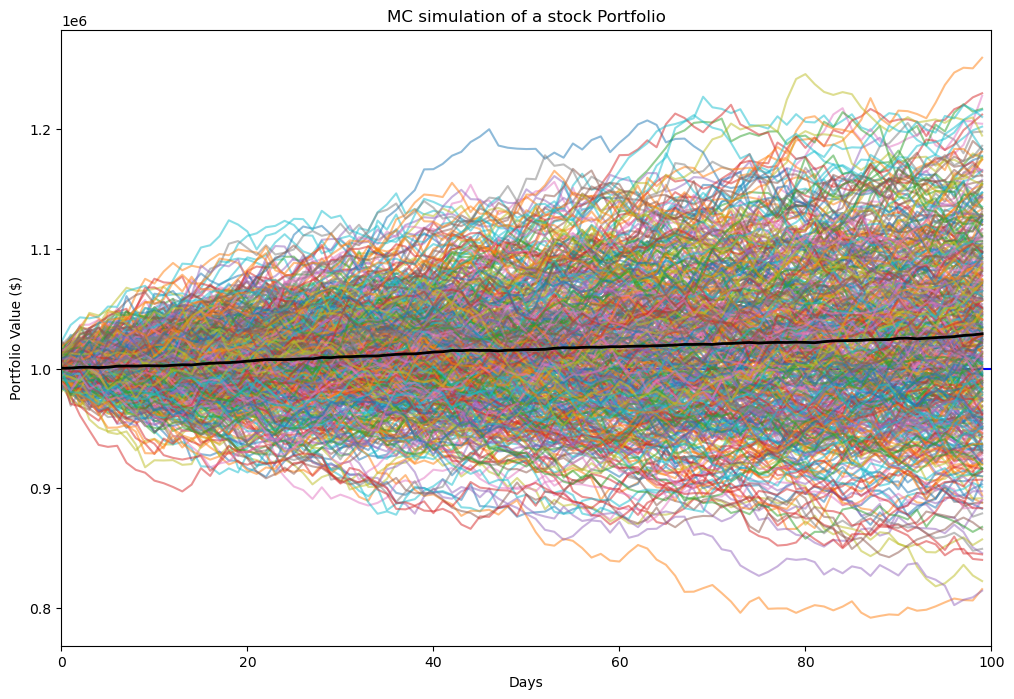

In [8]:
#Monte Carlo method
#number of simulatioins

sims = 500 #number of simulations 
T = 100 #timeframe in days 

meanM = np.full(shape=(T , len(weights)) , fill_value = meanReturns)
meanM = meanM.T

ptf_sims = np.full(shape = (T , sims) , fill_value = 0.0)

initial_ptf = 1000000

for m in range(0,sims):
    Z = np.random.normal(size = (T , len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L , Z)
    ptf_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_ptf


#ptf_sims_2 = ptf_sims.mean()
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(y=initial_ptf, color='b')
ax.plot(ptf_sims, alpha = 0.5)

average_portfolio = np.mean(ptf_sims, axis=1)
ax.plot(average_portfolio, color='black', linewidth=2, label='Average Portfolio Value')

ax.set_ylabel('Portfolio Value ($)')
ax.set_xlabel('Days')
ax.set_title('MC simulation of a stock Portfolio')
ax.set_xlim(0, T)

plt.show()

In [15]:
def mcVaR(returns, alpha=5):
    #imput : pandas series of returns
    #output : percentile on return distribution to a given confidence level alpha
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas Data series.")

In [16]:
def mcCVaR(returns, alpha=5):
    #imput : pandas series of returns
    #output : CVaR or expected shortfall to a given confidence level alpha
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas Data series.")

In [19]:
ptf_results = pd.Series(ptf_sims[-1,:])
VaR = initial_ptf - mcVaR(ptf_results, alpha=5)
CVaR = initial_ptf - mcCVaR(ptf_results ,alpha=5)

In [20]:
print('VaR ${}'.format(round(VaR, 2)))
print('CVaR ${}'.format(round(CVaR, 2)))

VaR $90493.47
CVaR $127166.24
